In [1]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional
from torch.utils.data import DataLoader,Dataset
import torch

import pandas as pd

import numpy as np

from datetime import datetime

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore')

# Model Creation

In [38]:
class LSTM(nn.Module):
    """This class allow creating a model consist of LSTM and Dense layers in order to forcast time series
    """
    def __init__(self,input_size,output_size,hidden_size,num_layers,device="cuda",dropout=None):
        """Constructor of our time serie forcasting model
            Args:
                input_size  : The nummber of feature of an input. In our case it is generaly equal to 1
                output_size : The number of output values of the model. In our case it generaly equal to 1
                hidden_size : The number of features in the hidden state h
                num_layers  :  Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs 

            Return : Nothing
        """
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")
        
        
        self.lstm= nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True,dropout=dropout) if dropout else nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(in_features=hidden_size,out_features=output_size)

    def forward(self,inputs):
        """Make the forword pass
            Args:
                inputs : The inputs which should be provided to model for the forward pass

            Return : The result of the forward pass 
        """
        batch_size=inputs.size(0)
        h=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(self.device)
        c=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(self.device)
        x,_=self.lstm(inputs,(h,c))
        return self.fc(x[:,-1,:])

    def train_one_epoch(self,train_loader,optimizer,loss_fn):
        
        """The function is use to train one epoch of the model
            Args: 
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader
                
        """
        running_loss = 0.0
        last_loss = 0.0
        for batch_index, batch in enumerate(train_loader):

            optimizer.zero_grad() # Putting gradient to zero in order to accumulate upcoming gradient

            #print(batch.size)
            data,target=batch[0].to(self.device),batch[1].to(self.device)
           # data,target=data.to(self.device),target.to(self.device)
          
            outputs=self(data) # Making prediction

            loss=loss_fn(outputs.to(self.device),target) # Computing the loss
            loss.backward() # Computing the gradient

            running_loss+=loss.item() # Accumulation loss through one epoch

            optimizer.step() # Updating weights

            if batch_index%100==99:
                last_loss=running_loss/100 # Computing loss per batch
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        return last_loss


    def validation_one_epoch(self,validation_loader,loss_fn):
        
        """The function is used to train one epoch of the model
            Args: 
                optimizer       : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function   : The loss function to use during the model validation. Same as the training one
                val_loader      : A torch DataLoader which is use to iterate through the data during validation step

            Return : The last loss value on the val_loader
                
        """
        avg_vloss = 0.
        running_loss=0.
        with torch.no_grad() :
            for batch in validation_loader:
    
                data,target=batch[0].to(self.device),batch[1].to(self.device)
                outputs=self(data) # Making prediction

                loss=loss_fn(outputs,target) # Computing the loss
                
                running_loss+=loss.item() # Accumulation loss through one epoch
                
        avg_vloss=running_loss/len(validation_loader)
                   
        return avg_vloss


    def predict(self,test_loader):

        """The function is used to train one epoch of the model
            Args: 
                test_loader      : A torch DataLoader which is use to iterate through the data during prediction step

            Return : Predicted and actual value of the test_loader
                
        """
        out=[]
        targets=[]
        with torch.no_grad() :
            for batch in tqdm(test_loader):
                data,target=batch[0].to('cuda'),batch[1]
                outputs=self(data) # Making prediction
    
                out.append(outputs[0].cpu())
                targets.append(target[0])
                
        return np.array(out), np.array(targets)

    def evaluation(self,y_test,predictions,metric="mse"):
        # Evaluate the model
        if metric=="mse" :print("Mean Squared Error (MSE):", mean_squared_error(y_test, predictions))
        elif metric =="mae" :print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predictions))
        

    def fit(self,train_loader,validation_loader,optimizer,loss_fn,epochs=100,device="cuda"):
        """The function is used to train the model through many epochs
            Args: 
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return
                
        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
            # print("\n")
            print("EPOCHS : {}".format(epoch +1))
            self.train(True) # Activate training mode
            avg_loss=self.train_one_epoch(train_loader,optimizer,loss_fn) # training the model on an epoch
            
            self.eval() # Setting the evaluation mode so that no gradient will be compute, that will save forward pass time
            avg_vloss=self.validation_one_epoch(validation_loader,loss_fn) # Evalution the model after one epoch
            print(f"Loss {avg_loss} vs Validation_loss  {avg_vloss}")

            if avg_vloss < best_avg_vloss :
                best_avg_vloss=avg_vloss
                model_path='/home/dah/timeSeries/time_series_forcasting/models/model_{}'.format(datetime.now().strftime('%Y%m%d_%H%')) 
                torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
                

# Custom dataset for training LSTM-based model

In [39]:
class TimeSerieDataset(Dataset):
    def __init__(self,data,time_step,batch_size,transform=None):
        super(TimeSerieDataset,self).__init__()
        self.time_step=time_step
        self.transform=transform
        self.data,self.target=self._sequence_generation(data,time_step)
        self.batch_size=batch_size

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):
        if index >=len(self.data) :
            raise "Out of range"
        # return self.data[index:min(index+self.batch_size,len(self.data))],self.target[index:min(index+self.batch_size,len(self.data))]
        return self.data[index],self.target[index]

    def _sequence_generation(self,data,time_step):
        X,y=list(),list()
        data=self.transform.fit_transform(data) if self.transform else data
        for i in range(len(data) - time_step):
            X.append(data[i:i+time_step,])
            y.append(data[i+time_step,])
            
        return torch.tensor(X,dtype=torch.float32).unsqueeze(-1),torch.tensor(y,dtype=torch.float32)
        
    

# The main function

In [42]:
def main():
    torch.manual_seed(0)
    
    input_size=1
    output_size=1
    hidden_size=512
    num_layers=1
    model=LSTM(input_size,1,hidden_size,num_layers)
    # print(f"mode.device {model.device}")
    # print(f"model {model}")

    humidity = pd.read_csv("/home/dah/deep_learning_isima/tp_reseaux recurrents/datasets/humidity.csv")
    temp = pd.read_csv("/home/dah/deep_learning_isima/tp_reseaux recurrents/datasets/temperature.csv")
    pressure = pd.read_csv("/home/dah/deep_learning_isima/tp_reseaux recurrents/datasets/pressure.csv")
    
    ville='Montreal'
    humidity_M = humidity[['datetime',ville]]
    temp_M = temp[['datetime',ville]]
    pressure_M = pressure[['datetime',ville]]

    

    humidity_M.interpolate(inplace=True)
    humidity_M.dropna(inplace=True)
    nb_samples = int(len(humidity_M)*0.90)
    
    humidity_train = np.array(humidity_M[ville][:nb_samples]).ravel()
    humidity_test = np.array(humidity_M[ville][nb_samples:]).ravel()
    
    temp_train = np.array(temp_M[ville][:nb_samples]).ravel()
    temp_test = np.array(temp_M[ville][nb_samples:]).ravel()
    
    pressure_train = np.array(pressure_M[ville][:nb_samples]).ravel()
    pressure_test = np.array(pressure_M[ville][nb_samples:]).ravel()


    
    
    # temp_M.interpolate(inplace=True)
    # temp_M.dropna(inplace=True)
    
    # pressure_M.interpolate(inplace=True)
    # pressure_M.dropna(inplace=True)

    time_step=8

    train_batch_size,test_batch_size=10,10
    xtrain=TimeSerieDataset(humidity_train,time_step,batch_size=train_batch_size)
    xtest=TimeSerieDataset(humidity_test,time_step,batch_size=test_batch_size)
    train_loader=DataLoader(dataset=xtrain,batch_size=train_batch_size,num_workers=15)
    test_loader=DataLoader(dataset=xtest,batch_size=test_batch_size,num_workers=15)

    optimizer=optim.Adam(model.parameters(),lr=1e-5)
    loss_fn=nn.MSELoss()

    model.fit(train_loader=train_loader,validation_loader=test_loader,optimizer=optimizer,loss_fn=loss_fn,epochs=200)

    #plt.plot(humidity_test)
    out,targets=model.predict(test_loader)
    

    plt.figure(figsize=(22, 4))
    plt.plot(out,label="Predicted")
    plt.plot(targets,label="Actual")
    plt.legend()
    plt.show()

    model.evaluation(out,targets,"mse")
    model.evaluation(out,targets,"mae")
    



EPOCHS : 1
Loss 127665.84281532287 vs Validation_loss  2040.3065556045128
EPOCHS : 2
Loss 56832.81813946724 vs Validation_loss  891.4665563317527
EPOCHS : 3
Loss 24414.468852107526 vs Validation_loss  381.48302214230057
EPOCHS : 4
Loss 11182.46591404438 vs Validation_loss  212.00044889576668
EPOCHS : 5
Loss 6668.312363912762 vs Validation_loss  163.24309845308287
EPOCHS : 6
Loss 5293.258579738271 vs Validation_loss  149.84749075691258
EPOCHS : 7
Loss 4883.262364026457 vs Validation_loss  145.89562977731757
EPOCHS : 8
Loss 4745.866542085335 vs Validation_loss  144.4450462455243
EPOCHS : 9
Loss 4687.862741957801 vs Validation_loss  143.7610561826588
EPOCHS : 10
Loss 4658.2901331845205 vs Validation_loss  143.2736669124755
EPOCHS : 11
Loss 4641.18107641507 vs Validation_loss  142.90056683742895
EPOCHS : 12
Loss 4630.518343261909 vs Validation_loss  142.5753012958881
EPOCHS : 13
Loss 4623.504223539382 vs Validation_loss  142.23715270304046
EPOCHS : 14
Loss 4618.5148328056 vs Validation_los

100%|█████████████████████████████| 452/452 [00:00<00:00, 535.05it/s]


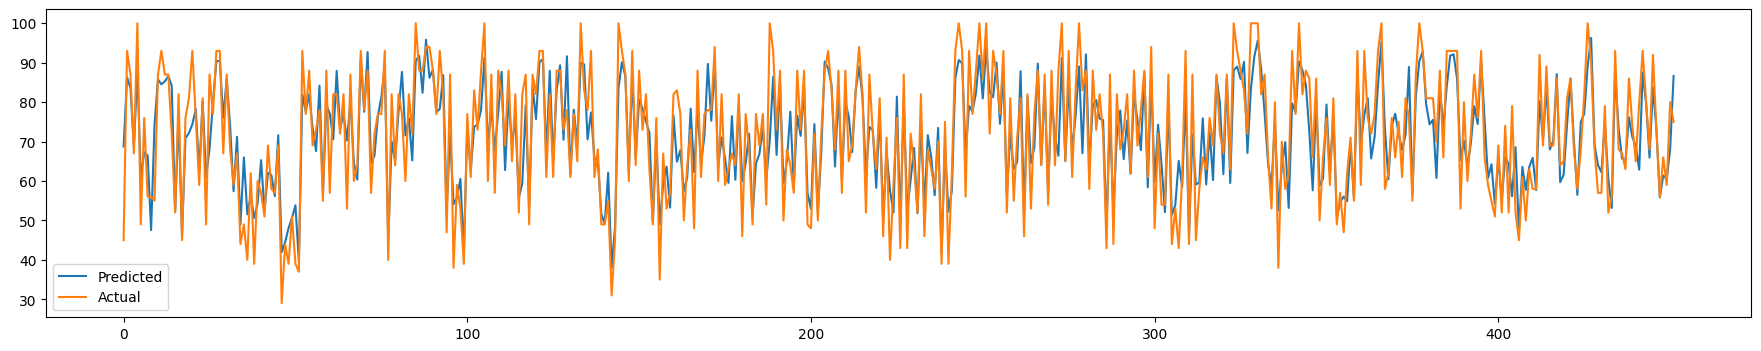

Mean Squared Error (MSE): 62.424291660139104
Mean Absolute Error (MAE): 6.354314905352297


In [43]:
if __name__=="__main__":
    main()